In [1]:
import json

from shapely.geometry import LineString
import shapely.geometry as sg


In [4]:
import os
import tempfile
from pathlib import Path
from shutil import unpack_archive, rmtree

import pandas as pd


def read_gtfs(path):
    """
    Given a path (string or pathlib object) to a (zipped) GTFS feed,
    unzip the feed and save the files to a dictionary whose keys are
    named after GTFS tables ('stops', 'routes', etc.) and whose
    corresponding values are Pandas data frames representing the tables.
    Return the resulting dictionary.

    NOTES:
        - Ignore files that are not valid GTFS; see https://developers.google.com/transit/gtfs/reference/.
        - Ensure that all ID fields that could be strings ('stop_id', 'route_id', etc.) are parsed as strings and not as numbers.
    """
    
    # GTFS valid filenames, and data types
    gtfs_filenames = ['agency', 'stops', 'routes', 'trips', 'stop_times', 'calendar', 'calendar_dates', 'fare_attributes', 'fare_rules', 'shapes', 'frequencies', 'transfers', 'feed_info']
    gtfs_filetypes = {'route_id': str, 'route_short_name': str, 'route_long_name': str, 'route_type': int, 'trip_id': str, 'route_id': str, 'service_id': str, 'block_id': str, 'stop_id': str, 'arrival_time': str, 'departure_time': str, 'stop_sequence': str, 'stop_lon': float, 'stop_lat': float}
    
    # Extract files
    #extracted_path = os.path.join(os.getcwd(), 'auckland_gtfs')
    extracted_path = tempfile.mkdtemp()
    unpack_archive(path, extract_dir=extracted_path, format='zip')
    
    # Dictionary to store tables in
    gtfs_data = dict()

    for filename in os.listdir(extracted_path):
        if filename.endswith('.txt') and filename[0:-4] in gtfs_filenames:
            tbl = pd.read_csv(Path(extracted_path)/filename, dtype=gtfs_filetypes)
            gtfs_data[filename[0:-4]] = tbl
    
    # delete temporary folder used for extracting files
    rmtree(extracted_path)
        
    return gtfs_data
    
    

In [5]:
gtfs_dir = pathlib.Path('../data/auckland_gtfs_20161017.zip')
feed = read_gtfs(str(gtfs_dir))


In [8]:
def build_geometry_by_shape(feed, shape_ids=None):
    """
    Given a GTFS feed object, return a dictionary with structure
    shape ID -> Shapely LineString representation of shape,
    where the dictionary ranges over all shapes in the feed.
    Use WGS84 longitude-latitude coordinates, the native coordinate system of GTFS.

    If a list of shape IDs ``shape_ids`` is given,
    then only include the given shape IDs in the dictionary.

    NOTES:
        - Raise a ValueError if the feed has no shapes
    """
    
    if not 'shapes' in feed:
        raise ValueError('No shapes in GTFS feed')
    
    # If shape_ids aren't specified, get all unique shape_ids, and use all of them
    if shape_ids is None:
        shape_ids = feed['shapes']['shape_id'].unique()
        
    all_shapes = dict()
        
    # Loop through all shape_ids to create shapely objects
    for shape in shape_ids:
        # Extract and order all parts of that shape
        my_shape = feed['shapes'].loc[feed['shapes']['shape_id'] == shape]
        my_shape = my_shape.sort_values('shape_pt_sequence', ascending=True)
        
        coords = [(j['shape_pt_lon'], j['shape_pt_lat']) for __, j in my_shape.iterrows()]
        
        if not coords: # If an invalid shape_id was supplied, there will be no coordinates
            continue
            
        all_shapes[shape] = sg.LineString(coords)
    
    return all_shapes

['827-20161011151756_v46.25' '554-20161011151756_v46.25']


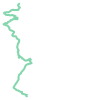

In [15]:
shids = feed['shapes']['shape_id'].unique()[:2]
print(shids)
d = build_geometry_by_shape(feed, shape_ids=shids)
d[shids[1]]

In [18]:
geom = d[shids[0]]
from shapely.geometry import mapping

mapping(geom)

{'coordinates': ((174.77834, -36.61193),
  (174.77836000000002, -36.611979999999996),
  (174.77844, -36.611959999999996),
  (174.77892, -36.61186),
  (174.77942, -36.61175),
  (174.7795, -36.61172),
  (174.77962, -36.61169),
  (174.77987, -36.61169),
  (174.77992, -36.61168),
  (174.77993, -36.61168),
  (174.77998, -36.611670000000004),
  (174.78032, -36.611540000000005),
  (174.78121000000002, -36.61122),
  (174.78171, -36.61105),
  (174.78185, -36.61101),
  (174.78197, -36.61098),
  (174.78208999999998, -36.61096),
  (174.78221000000002, -36.610929999999996),
  (174.78233, -36.61092),
  (174.78246000000001, -36.6109),
  (174.78264, -36.61088),
  (174.78283000000002, -36.61087),
  (174.78308, -36.61085),
  (174.78343, -36.61083),
  (174.78343, -36.61081),
  (174.78343, -36.61083),
  (174.78387, -36.6108),
  (174.78405, -36.6108),
  (174.78412, -36.61079),
  (174.78425, -36.61079),
  (174.78438, -36.6108),
  (174.78451, -36.6108),
  (174.78464, -36.61081),
  (174.78477, -36.61083),
  (

In [16]:
def trip_to_geojson(feed, trip_id):
    """
    Given a GTFS feed object and a trip ID from that feed,
    return a GeoJSON LineString feature (as a Python dictionary)
    representing the trip's geometry and its metadata
    (trip ID, direction ID, headsign, etc.).
    Use WGS84 coordinates, the native coordinate system of GTFS.

    NOTES:
        Raise a ``ValueError`` if the appropriate GTFS data does not exist.
    """
    
    # get shape_id
    shape_id = feed['trips'].loc[feed['trips']['trip_id'] == trip_id]['shape_id']
    if len(shape_id) < 1:
        raise ValueError('Invalid trip_id')
    else:
        shape_id = shape_id.values[0]
        
    # convert to geojson compatible
    my_shape = build_geometry_by_shape(feed, [shape_id])
    my_shape = sg.mapping(my_shape[shape_id])
    
    # add metadata
    #my_shape['trip_id'] = trip_id
    #my_shape['direction_id'] = feed['trips'].loc[feed['trips']['trip_id']==trip_id]['direction_id'].values[0]
    #my_shape['headsign'] = feed['trips'].loc[feed['trips']['trip_id']==trip_id]['trip_headsign'].values[0]
    
    return my_shape

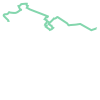

In [6]:
all_shapes = build_geometry_by_shape(feed, ['826-20161011151756_v46.25'])
all_shapes['826-20161011151756_v46.25']

In [7]:
trip_id = '2365061662-20161011155909_v46.26'
my_shape = trip_to_geojson(feed, trip_id)


In [ ]:
json.dumps(my_shape)
